# Food Vision (Multiclass)

This introduction exercise demonstrates classification with the following key steps:

- **Dataset** (Exploring custom data)
- **Augmented** (Aplying pytorch `transforms.TrivialAugmentWide()`)
- **Data Loader** (Exploring batches principle)
- **Model Class**
    - Layer stack with `nn.Sequence`
    - Adam for optimizer
    - `nn.CrossEntropyLoss()` for multiclass loss function
- **Training Loop** (Training the Model)
- **Train visualization** (Train & test losses graph interpretation)



*Note: Gogle colab*

# Get the dataset

In [1]:
import os
import wget
import zipfile

# Function to extract the zip file
def extract_zip(zip_path, extract_to):
    print(f"\nExtracting {zip_path} to {extract_to}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")
    
# Define the folder path, file path, and URL
folder_path = "food_vision"
file_path = os.path.join(folder_path, 'pizza_steak_sushi.zip')  # Save the zip file inside the folder
url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

# Check if the folder exists
if not os.path.exists(folder_path):
    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)
    
    # Download the file
    print("File not exist, start downloading")
    wget.download(url, file_path)
    extract_zip(file_path, folder_path)
    
else:
    print(f"File already exists at {file_path}.")
    if not os.path.join(folder_path, 'train'):
        extract_zip(file_path, folder_path)
    else:
        rewrite = input("File already exists and look like allready extracted, overwrite: y/n: ")
        if rewrite.lower() == 'y':
            extract_zip(file_path, folder_path)
        else:
            print("Bye!")


File already exists at food_vision\pizza_steak_sushi.zip.


File already exists and look like allready extracted, overwrite: y/n:  n


Bye!


Random image path: food_vision\test\sushi\684266.jpg
Image class: sushi
Image height: 512
Image width: 512


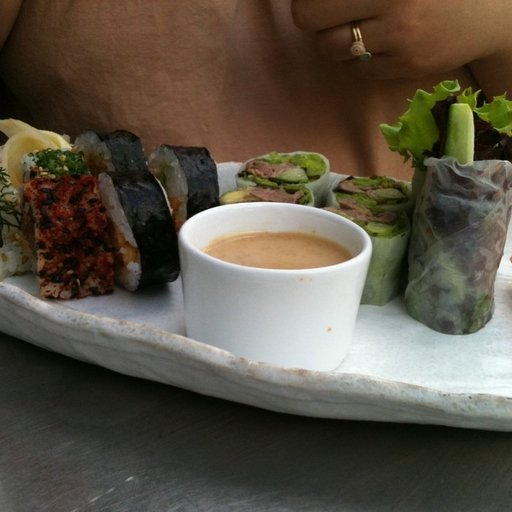

In [2]:
import random
from PIL import Image
import glob

# Set seed
# random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list = glob.glob(os.path.join(folder_path, '**', '*.jpg'), recursive=True)

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = os.path.basename(os.path.dirname(random_image_path))

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

## Data processing

Introducing `TrivialAugmentWide()` : https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [3]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [43]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(128, 128)),
    # Do set of transfor called Trivial Augment Wide with strength = 8 < Change it
    transforms.TrivialAugmentWide(8),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

## Data Visualizing

In [39]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    # random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {os.path.basename(os.path.dirname(image_path))}", fontsize=16)

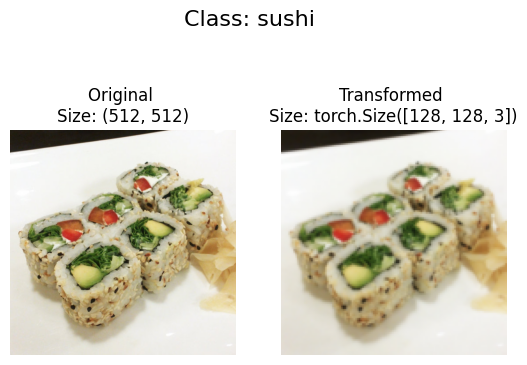

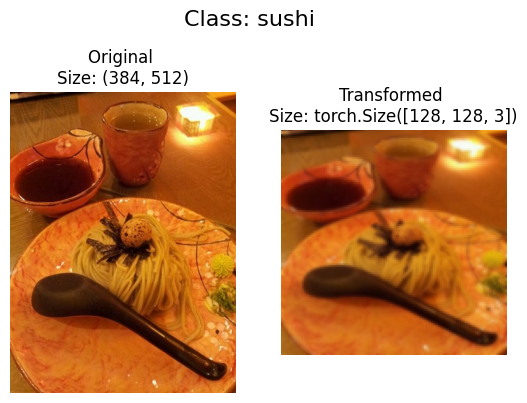

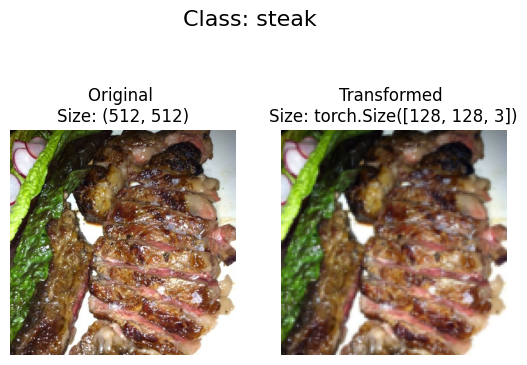

In [44]:
# Run multiple time to get different image 😍
plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [7]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=os.path.join(folder_path, 'train'), transform=data_transform)
test_data = ImageFolder(root=os.path.join(folder_path, 'test'), transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: food_vision\train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=21, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: food_vision\test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=21, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ))

In [34]:
from torch.utils.data import DataLoader

# Batch size
BATCH_SIZE = 8

# Turn dataset to batches
train_loader = DataLoader(train_data, # Pick train data
                          batch_size=BATCH_SIZE, # Make it batches
                          shuffle=True # We will shuffle every epoch
                          )
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
# Checking
print(f"Length of train dataloader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_loader)} batches of {BATCH_SIZE}")
print(f"Length of train data: {len(train_data)}")
print(f"Length of test data: {len(test_data)}")

Length of train dataloader: 29 batches of 8
Length of test dataloader: 10 batches of 8
Length of train data: 225
Length of test data: 75


In [10]:
# Check what classes/label available
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

# Model Architecture

In [85]:
from torch import nn

class Vgg(nn.Module):
  def __init__(self, input, hidden_layer, output):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                  out_channels=hidden_layer,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layer,
                  out_channels=hidden_layer,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.MaxPool2d(kernel_size=3,
                         stride=3) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_layer,
                  out_channels=hidden_layer,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_layer,
                  out_channels=hidden_layer,
                  kernel_size=3,
                  padding=0,
                  stride=1),
        nn.MaxPool2d(2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_layer*18*18, out_features=output)
    )
      
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)  # Second convolution block (with pooling)
    # print(x.shape)
    return self.classifier(x)

## Model initializing

In [95]:
torch.manual_seed(42)
model = Vgg(input=3, # 3 color channel 😉 as input, put 1 if grayscale
            hidden_layer=10, 
            output=len(class_names))

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.002)

print(model)

Vgg(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3240, out_features=3, bias=True)
  )
)


## Shape miss match debug

**This section designed to make Errors**

How it works:
1. Make sure enable `print(x.shape)` in forward pass
2. Test the model with a batch
3. The last print will use to adjust this line parameter: `nn.Linear(in_features=hidden_layer*7*7, out_features=output)`

**Example:**

`nn.Linear(in_features=hidden_layer*7*7, out_features=output)`

And a batch test give:

`Single image shape: torch.Size([1, 3, 128, 128])`

`torch.Size([1, 10, 42, 42])`

`torch.Size([1, 10, 20, 20])`

Then we replace `7*7` with `20*20` thats it!

In [84]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_loader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single)
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
# print(f"Output logits:\n{pred}\n")
# print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
# print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
# print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 128, 128])

torch.Size([1, 10, 41, 41])
torch.Size([1, 10, 18, 18])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x3240 and 4000x3)

## Training Loop

In [96]:
num_epochs = 34

train_losses_per_epoch = []  # To store average train losses per epoch
test_losses_per_epoch = []   # To store average test losses per epoch

for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}\n-------")

    train_losses = []
    test_losses = []
    train_acc = []

    # Looping through batches
    for batch, (inputs, labels) in enumerate(train_loader):
        model.train()

        # Forward pass (Training)
        y_pred = model(inputs)
        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        correct = (y_pred_class == labels).sum().item()  # Calculate the number of correct predictions
        acc = correct / len(labels)  # Accuracy for the batch
        train_acc.append(acc)

        # Calculate loss (Training)
        train_loss = loss_fn(y_pred, labels)
        train_losses.append(train_loss.item())

        # Optimizer zero grad
        optimizer.zero_grad()

        # Backward pass
        train_loss.backward()

        # Optimizer step
        optimizer.step()

        # TESTING (Evaluation)
        model.eval()
        with torch.no_grad():  # Use no_grad() to save memory during inference
            test_pred = model(inputs)
            test_loss = loss_fn(test_pred, labels)
            test_losses.append(test_loss.item())

        if batch % 8 == 0:
            print(f"Looked at batch {batch * len(inputs)}/{len(train_data)} samples")

    # Calculate average losses for the epoch
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_test_loss = sum(test_losses) / len(test_losses)
    avg_train_acc = sum(train_acc) / len(train_acc)

    # Append the average losses of the epoch to the lists for plotting
    train_losses_per_epoch.append(avg_train_loss)
    test_losses_per_epoch.append(avg_test_loss)
    
    print(f"\nTrain loss: {avg_train_loss:.5f} | Test loss: {avg_test_loss:.5f} | Train Accuracy: {avg_train_acc:.5f}\n")

Epoch: 1
-------
Looked at batch 0/225 samples
Looked at batch 64/225 samples
Looked at batch 128/225 samples
Looked at batch 192/225 samples

Train loss: 1.15419 | Test loss: 1.11724 | Train Accuracy: 0.31034

Epoch: 2
-------
Looked at batch 0/225 samples
Looked at batch 64/225 samples
Looked at batch 128/225 samples
Looked at batch 192/225 samples

Train loss: 1.09439 | Test loss: 1.08211 | Train Accuracy: 0.35345

Epoch: 3
-------
Looked at batch 0/225 samples
Looked at batch 64/225 samples
Looked at batch 128/225 samples
Looked at batch 192/225 samples

Train loss: 1.04919 | Test loss: 1.01640 | Train Accuracy: 0.43534

Epoch: 4
-------
Looked at batch 0/225 samples
Looked at batch 64/225 samples
Looked at batch 128/225 samples
Looked at batch 192/225 samples

Train loss: 1.04212 | Test loss: 1.01903 | Train Accuracy: 0.40517

Epoch: 5
-------
Looked at batch 0/225 samples
Looked at batch 64/225 samples
Looked at batch 128/225 samples
Looked at batch 192/225 samples

Train loss: 1

# Evaluation

Refference for reading train loss graph:

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

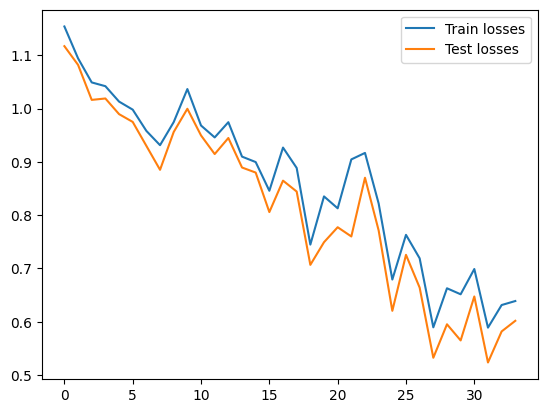

In [98]:
# Plot Train losses vs test losses Matplotlib version
plt.plot(range(num_epochs), train_losses_per_epoch, label='Train losses')
plt.plot(range(num_epochs), test_losses_per_epoch, label='Test losses')
plt.legend()